In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
    get_tuids_containing,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = "20250526-030840-970-e4dc7c"
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 626kB
Dimensions:  (dim_0: 1700)
Coordinates: (12/15)
    x0       (dim_0) float64 14kB 6.972e+09 6.992e+09 ... 6.993e+09 6.993e+09
    x1       (dim_0) float64 14kB 0.02712 0.005 0.005 ... 0.04806 0.04715
    x2       (dim_0) float64 14kB 2e-08 5.6e-08 2e-08 ... 7.2e-08 7.2e-08
    x3       (dim_0) float64 14kB 7.601e+09 7.618e+09 ... 7.615e+09 7.615e+09
    x4       (dim_0) float64 14kB 0.009784 0.009974 0.01843 ... 0.0554 0.05509
    x5       (dim_0) float64 14kB 3.6e-08 5.2e-08 2e-08 ... 5.6e-08 5.6e-08
    ...       ...
    x9       (dim_0) float64 14kB 7.391e+09 7.384e+09 ... 7.413e+09 7.413e+09
    x10      (dim_0) float64 14kB 0.005 0.1102 0.009233 ... 0.06497 0.06404
    x11      (dim_0) float64 14kB 2e-08 4.4e-08 2e-08 ... 6.4e-08 6e-08 6.4e-08
    x12      (dim_0) float64 14kB 7.77e+09 7.781e+09 ... 7.786e+09 7.786e+09
    x13      (dim_0) float64 14kB 0.005 0.01465 0.005 ... 0.07126 0.07023
    x14      (dim_0) float64 14kB 3.2e-08 4.4e-08 2e-08 ... 6.8e-08 6.4e-08
Dimensions without coordinates: dim_0
Data variables: (12/31)
    y0       (dim_0) float64 14kB -5.997 -8.208 -7.711 ... -22.87 -23.69 -23.5
    y1       (dim_0) float64 14kB 0.5644 0.6045 0.5545 ... 0.9322 0.9346 0.9323
    y2       (dim_0) float64 14kB 0.548 0.5831 0.5376 ... 0.9792 0.9803 0.978
    y3       (dim_0) float64 14kB 0.5901 0.6418 0.5611 ... 0.9884 0.9895 0.9887
    y4       (dim_0) float64 14kB 0.5549 0.5887 0.5648 ... 0.8292 0.8341 0.83
    y5       (dim_0) float64 14kB 0.5281 0.5222 0.5 ... 0.9441 0.9518 0.9511
    ...       ...
    y25      (dim_0) float64 14kB 0.5386 0.6038 0.5535 ... 0.9156 0.9087 0.9082
    y26      (dim_0) float64 14kB 0.5361 0.6413 0.5261 ... 0.9877 0.9861 0.9875
    y27      (dim_0) float64 14kB 0.5352 0.6023 0.5649 ... 0.9791 0.9791 0.9788
    y28      (dim_0) float64 14kB 0.5445 0.5679 0.5695 ... 0.7801 0.7608 0.7584
    y29      (dim_0) float64 14kB 0.5 0.5287 0.5 0.5 ... 0.9687 0.9678 0.9628
    y30      (dim_0) float64 14kB 0.5082 0.5322 0.5064 ... 0.9363 0.9507 0.9466
Attributes:
    tuid:                             20250526-030840-970-e4dc7c
    name:                             CMAES_QNDPi_Readout_Adaptive_Reps ['D1'...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True
    elements:                         ['D1', 'X1', 'D2', 'Z1', 'D4']
    edges:                            []

In [4]:
def process_fidelity_data(dataset, popsize, n_qubits):
    """
    Processes fidelity data for n qubits based on the given dataset and population size.

    Parameters:
        dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
        popsize: The size of the population.
        n_qubits: The number of qubits.

    Returns:
        A dictionary containing mean and population fidelity data for all qubits and shared parameters.
    """
    qubits = dataset.elements
    # Extract parameters shared across all qubits
    shared_data = {
        'objective': dataset.y0.data,
    }

    # Initialize dictionary to hold data for each qubit
    fidelity_data = {'shared': shared_data}

    for q in range(n_qubits):
        # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
        start_idx = 1 + q* 6
        # Extract fidelity data for the current qubit
        fidelity_data[qubits[q]] = {
            'freq': getattr(dataset, f'x{q*3}').data,
            'ampl': getattr(dataset, f'x{q*3 + 1}').data,
            'dur': getattr(dataset, f'x{q*3 + 2}').data,            
            'assfid_av': getattr(dataset, f'y{start_idx}').data,
            'assfid_01': getattr(dataset, f'y{start_idx + 1}').data,
            'assfid_02': getattr(dataset, f'y{start_idx + 2}').data,
            'assfid_12': getattr(dataset, f'y{start_idx + 3}').data,
            'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
            'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
        }

        # Calculate mean fidelity values
        fidelity_data[qubits[q]]['mean'] = {
            key: fidelity_data[qubits[q]][key][popsize::popsize + 1]
            for key in ['freq','ampl', 'dur', 'assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }

        # print(fidelity_data[f'q{q}']['assfid_av'][0::popsize+1])
        # Calculate population fidelity values using the new slicing logic
        fidelity_data[qubits[q]]['pop'] = {
            key: np.array([
                fidelity_data[qubits[q]][key][i::popsize+1]
                for i in range(popsize)
            ])
            for key in ['freq','ampl', 'dur', 'assfid_av', 'assfid_01', 'assfid_02', 'assfid_12', 'qndfid', 'qndpifid']
        }


    return fidelity_data

In [5]:
Ngen = 100
n_qubits = 5
popsize = 16

fidelity_results = process_fidelity_data(dataset, popsize, n_qubits)

1
4
7
10
13


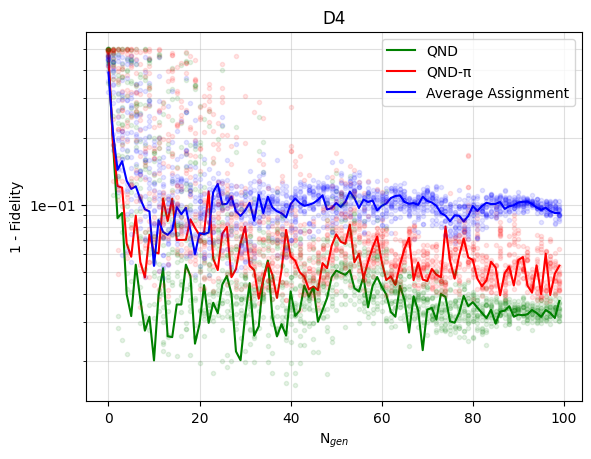

In [21]:
qubits = [dataset.elements[-1]]

for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    qnd_pi_pop = fidelity_results[qubit]['pop']['qndpifid']
    
    qnd_mean = fidelity_results[qubit]['mean']['qndfid']
    qnd_pop = fidelity_results[qubit]['pop']['qndfid']
    
    ass_fid_mean = fidelity_results[qubit]['mean']['assfid_av']
    ass_fid_pop = fidelity_results[qubit]['pop']['assfid_av']
    
    fid_12 = fidelity_results[qubit]['mean']['assfid_12']
    
    generations = range(Ngen)
    
    # Plot mean values
    plt.plot(generations, 1 - qnd_mean, c="green", label="QND")
    plt.plot(generations, 1 - qnd_pi_mean, c="red", label="QND-π")
    plt.plot(generations, 1 - ass_fid_mean, c="blue", label="Average Assignment")
    
    # Plot population data
    for j in range(popsize):
        plt.plot(generations, 1 - qnd_pop[j], ".", c="green", alpha=0.1)
        plt.plot(generations, 1 - qnd_pi_pop[j], ".", c="red", alpha=0.1)
        plt.plot(generations, 1 - ass_fid_pop[j], ".", c="blue", alpha=0.1)
    
    # Formatting
    plt.grid(which="both", alpha = .4)
    plt.xlabel(r"N$_{gen}$")
    plt.ylabel("1 - Fidelity")
    plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.yscale('log')

    ticks = np.arange(

    plt.show()


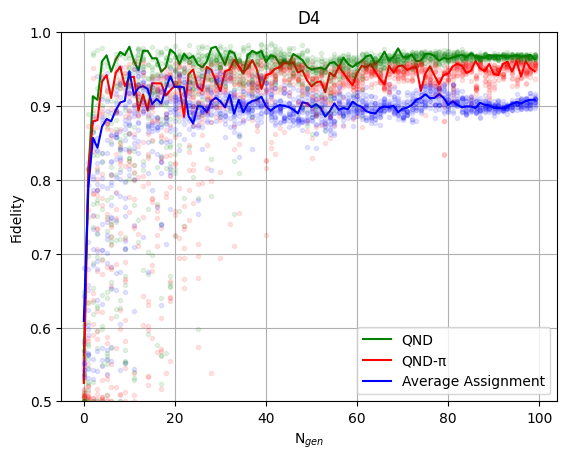

In [20]:
from matplotlib.ticker import LogLocator, LogFormatter
qubits = [dataset.elements[-1]]

for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    qnd_pi_pop = fidelity_results[qubit]['pop']['qndpifid']
    
    qnd_mean = fidelity_results[qubit]['mean']['qndfid']
    qnd_pop = fidelity_results[qubit]['pop']['qndfid']
    
    ass_fid_mean = fidelity_results[qubit]['mean']['assfid_av']
    ass_fid_pop = fidelity_results[qubit]['pop']['assfid_av']
    
    fid_12 = fidelity_results[qubit]['mean']['assfid_12']
    
    generations = range(Ngen)
    
    # Plot mean values
    plt.plot(generations, qnd_mean, c="green", label="QND")
    plt.plot(generations, qnd_pi_mean, c="red", label="QND-π")
    plt.plot(generations, ass_fid_mean, c="blue", label="Average Assignment")
    
    # Plot population data
    for j in range(popsize):
        plt.plot(generations, qnd_pop[j], ".", c="green", alpha=0.1)
        plt.plot(generations, qnd_pi_pop[j], ".", c="red", alpha=0.1)
        plt.plot(generations, ass_fid_pop[j], ".", c="blue", alpha=0.1)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"N$_{gen}$")
    plt.ylabel("Fidelity")
    plt.legend()
    plt.title(qubit)
    plt.ylim(0.5, 1)
    plt.show()


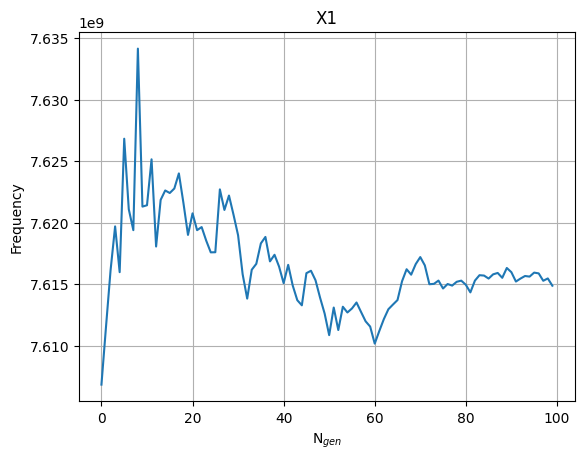

In [141]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    
    generations = range(Ngen)
    
    # Plot mean values
    plt.plot(generations, frequency_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"N$_{gen}$")
    plt.ylabel("Frequency")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

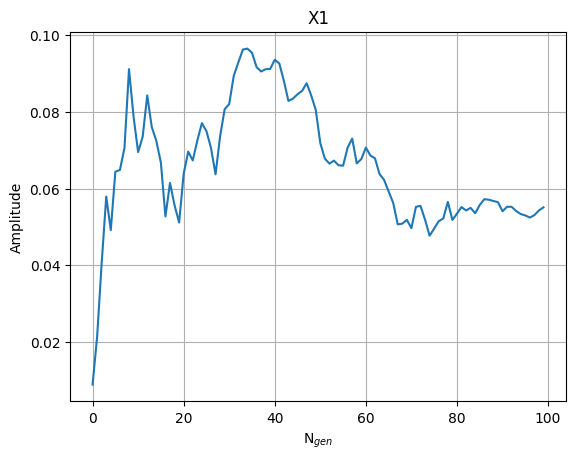

In [142]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    
    generations = range(Ngen)
    
    # Plot mean values
    plt.plot(generations, amplitude_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"N$_{gen}$")
    plt.ylabel("Amplitude")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

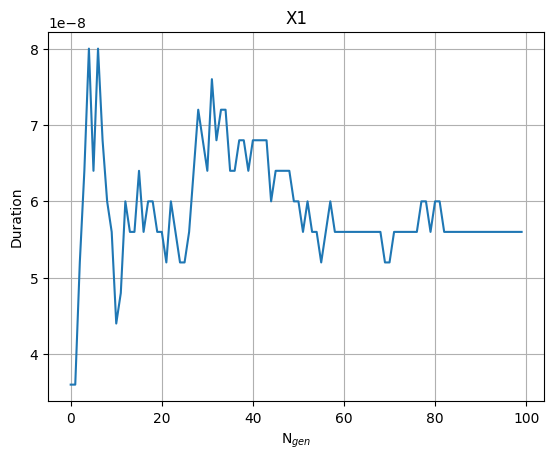

In [143]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    
    generations = range(Ngen)
    
    # Plot mean values
    plt.plot(generations, duration_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"N$_{gen}$")
    plt.ylabel("Duration")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

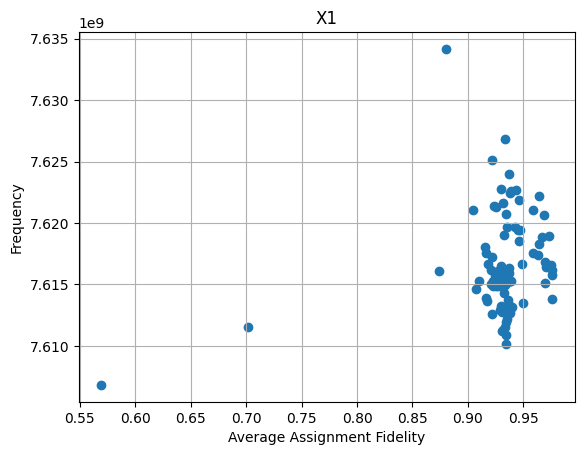

In [144]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(av_ass_mean, frequency_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"Average Assignment Fidelity")
    plt.ylabel("Frequency")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

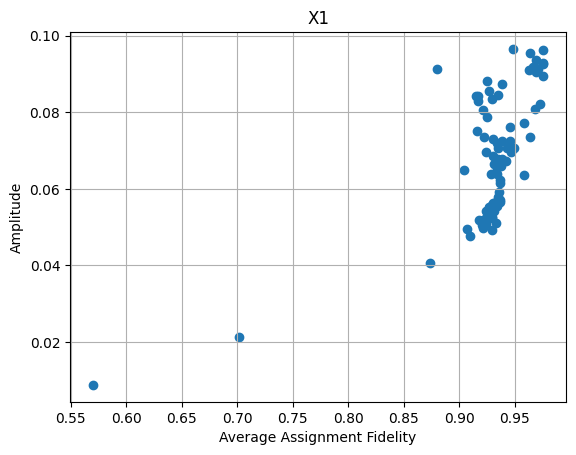

In [145]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(av_ass_mean, amplitude_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"Average Assignment Fidelity")
    plt.ylabel("Amplitude")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

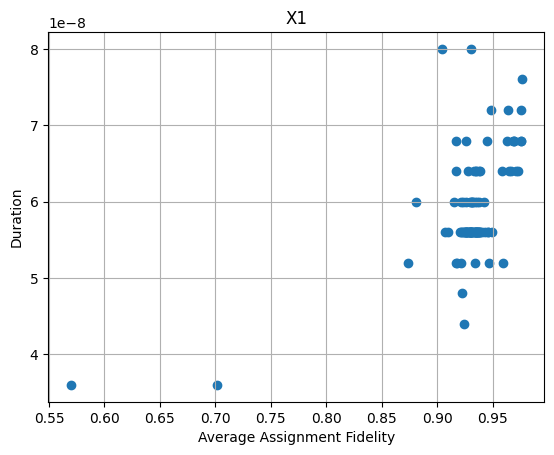

In [146]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(av_ass_mean, duration_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"Average Assignment Fidelity")
    plt.ylabel("Duration")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

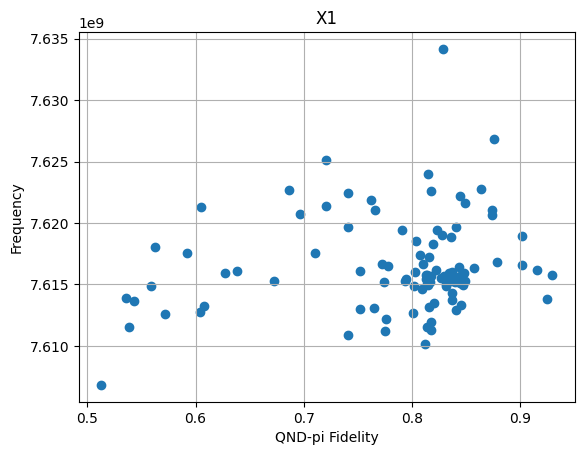

In [147]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(qnd_pi_mean, frequency_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"QND-pi Fidelity")
    plt.ylabel("Frequency")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

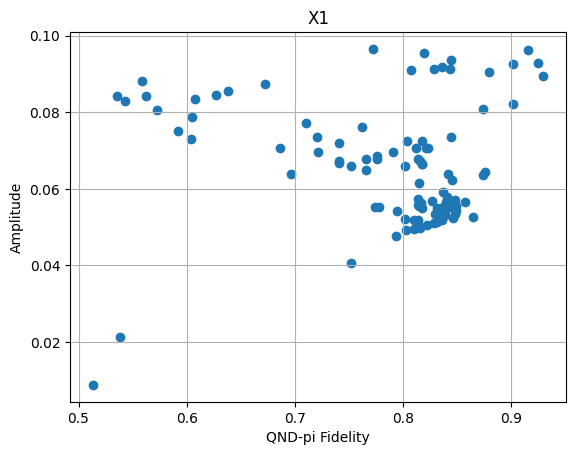

In [148]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(qnd_pi_mean, amplitude_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"QND-pi Fidelity")
    plt.ylabel("Amplitude")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()

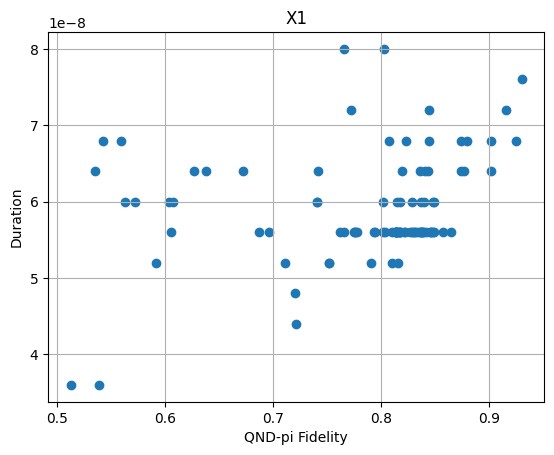

In [149]:
for qubit in qubits:
    frequency_mean = fidelity_results[qubit]['mean']['freq']
    amplitude_mean = fidelity_results[qubit]['mean']['ampl']
    duration_mean = fidelity_results[qubit]['mean']['dur']
    qnd_pi_mean = fidelity_results[qubit]['mean']['qndpifid']
    av_ass_mean = fidelity_results[qubit]['mean']['assfid_av']
    
    # generations = range(Ngen)
    
    # Plot mean values
    plt.scatter(qnd_pi_mean, duration_mean)
    
    # Formatting
    plt.grid()
    plt.xlabel(r"QND-pi Fidelity")
    plt.ylabel("Duration")
    # plt.legend()
    plt.title(qubit)
    # plt.ylim(0.5, 1)
    plt.show()